# Selection of MC data

## This notebook:

- Uses Monte Carlo data.
- Selects events with 1 S1 and 1 S2.
- Writes a dst DataFrame

## Authors: JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

### Description:

- Uses Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4 MC production. January 2019. 


In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Feb 19 10:58:13 2019


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import seaborn as sns
sns.set()

In [4]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [5]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import write_monitor_vars
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2d, plot_histo

In [6]:
from krcal.core.kr_types           import PlotLabels
from krcal.core.analysis_functions import kr_ranges_and_bins
from krcal.core.analysis_functions import kr_event
from krcal.core.analysis_functions import selection_info
from krcal.core.analysis_functions import selection_in_band
from krcal.core.analysis_functions import plot_selection_in_band
from krcal.core.s1s2_functions     import s1d_from_dst
from krcal.core.s1s2_functions     import s2d_from_dst
from krcal.core.s1s2_functions     import plot_s1histos
from krcal.core.s1s2_functions     import plot_s2histos

In [7]:
from krcal.core.plt_functions      import plot_xy_density
from krcal.core.plt_functions      import plot_s1_vs_z
from krcal.core.plt_functions      import plot_s2_vs_z
from krcal.core.plt_functions      import plot_s2_vs_s1
from krcal.core.plt_functions      import plot_q_vs_s2
from krcal.core.plt_functions      import plot_energy_distributions
from krcal.core.plt_functions      import plot_energy_vs_t


In [8]:
import krcal.dev.corrections       as corrections 
import krcal.utils.hst_extend_functions as hst

In [9]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core import fit_functions_ic as fitf
from krcal.core.histo_functions import profile1d

### Input/output 

In [10]:
path   = os.path.expandvars("/home/jmbenlloch/next/new/Kr/kdst/")
files  = "Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4*.h5"
filenames = "".join([path, files])
input_dst_filenames  = glob.glob(os.path.expandvars(filenames))
output_dst_filename = "".join(['/home/jmbenlloch/next/new/Kr/dst/', 'Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.h5'])

write_filtered_dst = True

In [11]:
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f'size of input dst = {len(input_dst_filenames)}')
print(f"output dst = {output_dst_filename}")                     

input dsts:
 first = /home/jmbenlloch/next/new/Kr/kdst/Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.556_5.h5
 last = /home/jmbenlloch/next/new/Kr/kdst/Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.9_9.h5
size of input dst = 10000
output dst = /home/jmbenlloch/next/new/Kr/dst/Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.h5


In [12]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

In [13]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 8126428 
Total number of events: 8119730


In [14]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [15]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 8126428


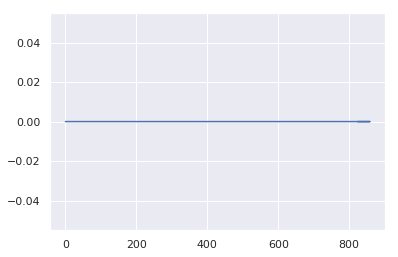

In [16]:
plt.plot(dst_full.time)

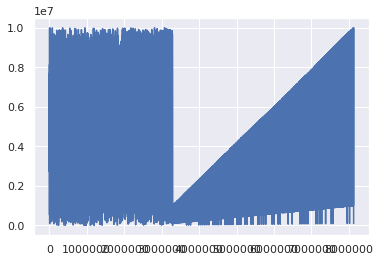

In [17]:
plt.plot(np.arange(len(dst_full)), dst_full.event)

In [18]:
dst_full.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,5565000,0.0,0,0,1,1,275.0,1.923226,17.913965,100125.0,...,14,427.372894,427.372894,1.721399,-32.356551,142.518023,146.144905,1.794047,18.279760,8.341938
1,5565001,0.0,0,0,1,1,125.0,2.998201,11.743582,100150.0,...,17,333.361633,333.361633,1.526073,-126.224622,146.847549,193.641054,2.280816,8.944377,8.628169
2,5565002,0.0,0,0,1,1,175.0,2.928624,16.042461,100150.0,...,17,44.310112,44.310112,0.751968,89.955412,-140.547459,166.869902,-1.001458,9.587814,8.449880
3,5565003,0.0,0,0,1,1,150.0,1.568315,8.226583,100150.0,...,14,139.326065,139.326065,1.101267,170.137934,-71.764980,184.654080,-0.399161,7.845877,7.407328
4,5565005,0.0,0,0,1,1,125.0,2.065100,7.844694,100175.0,...,17,157.319046,157.319046,1.338060,-37.587102,-165.658079,169.868741,-1.793914,8.189825,7.942866


In [19]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (1, 25)
s2e_range = (1000, 15000)
s2w_range =(4, 15)
s2q_range = (200, 800)
Nsipm_min = 10
xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst_full,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 50,
                                                        s2qnbins  = 50,
                                                        tpsamples = 3600) # tsamples in seconds

### Time
- Extension in hours of data sample considered

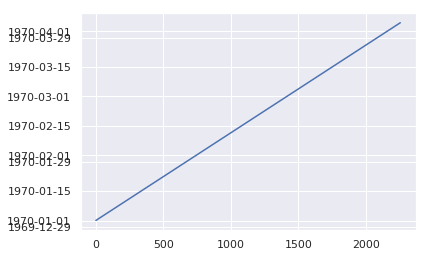

In [20]:
plt.plot(krTimes.timeStamps)

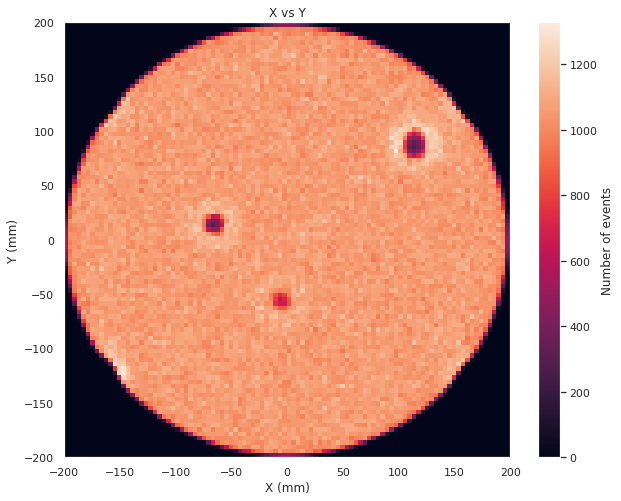

In [22]:
nevt = h2d(dst_full.X, dst_full.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### S1/S2

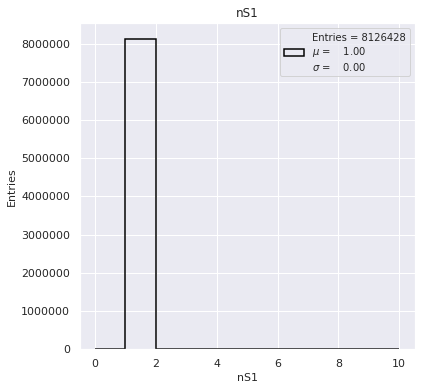

In [23]:
n, b, _, _ = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [24]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 1.0


#### Fraction of events with 1 S1 is 0.5. For Krypton select events with 1 S1

### Select events with 1 S1

In [25]:
dst1s1 = dst_full[dst_full.nS1==1]

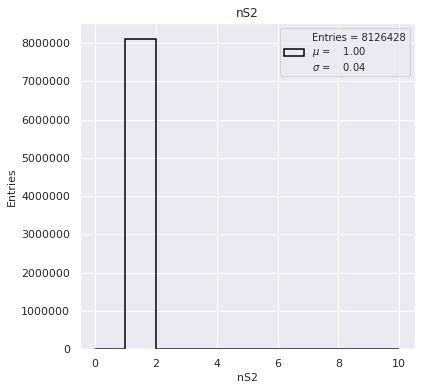

In [26]:
n, b, _, _ = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

#### For Krypton select events with only 1 S2

In [27]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.9983516743149635


### Select events with 1 S2

In [28]:
dst    = dst1s1[dst1s1.nS2==1]

In [29]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 8113033: selection eff = 0.9983516743149635 


### S1 and S2 distributions

In [30]:
s1d = s1d_from_dst(dst)

warning, empty slice of x = [100125. 100150. 100150. ... 100100. 100125. 100150.] in range = (0, 600)
returning mean and std of x = [100125. 100150. 100150. ... 100100. 100125. 100150.]


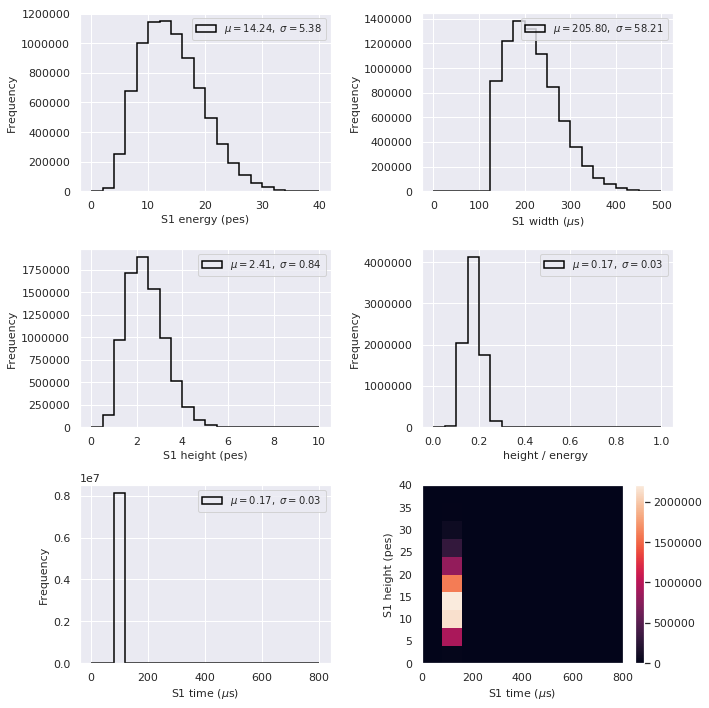

In [31]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

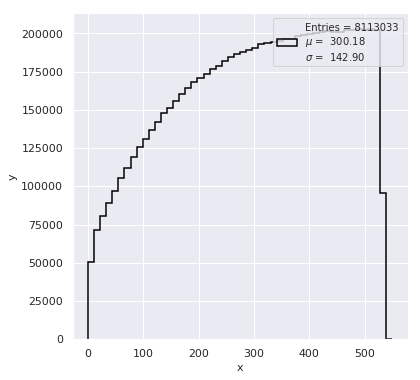

In [32]:
(_) = h1d(dst.Z, bins = 50, range =(0,550))

#### MC production, S1 and S2 in fixed positions.

## Fiducial selection 

In [33]:
dst_s1e    = dst[in_range(dst.S1e, *s1e_range)] 
dst_s2e    = dst_s1e[in_range(dst_s1e.S2e, *s2e_range)] 
dst_s2w    = dst_s2e[in_range(dst_s2e.S2w, *s2w_range)]
dst_sipm   = dst_s2w[dst_s2w.Nsipm > Nsipm_min] 
dst_s2q    = dst_sipm[in_range(dst_sipm.S2q, *s2q_range)]
dst       = dst_s2q

warning, empty slice of x = [100125. 100150. 100150. ... 100100. 100125. 100150.] in range = (0, 600)
returning mean and std of x = [100125. 100150. 100150. ... 100100. 100125. 100150.]


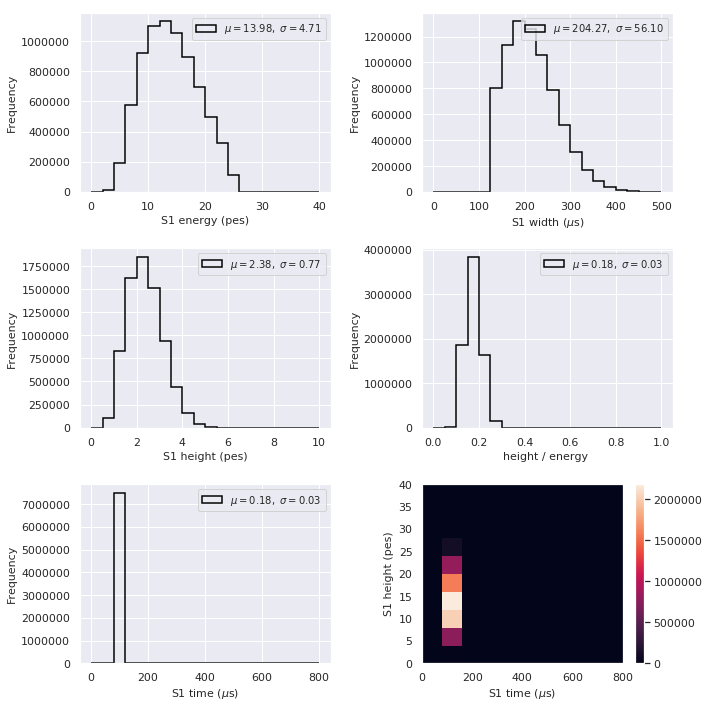

In [34]:
s1d = s1d_from_dst(dst)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

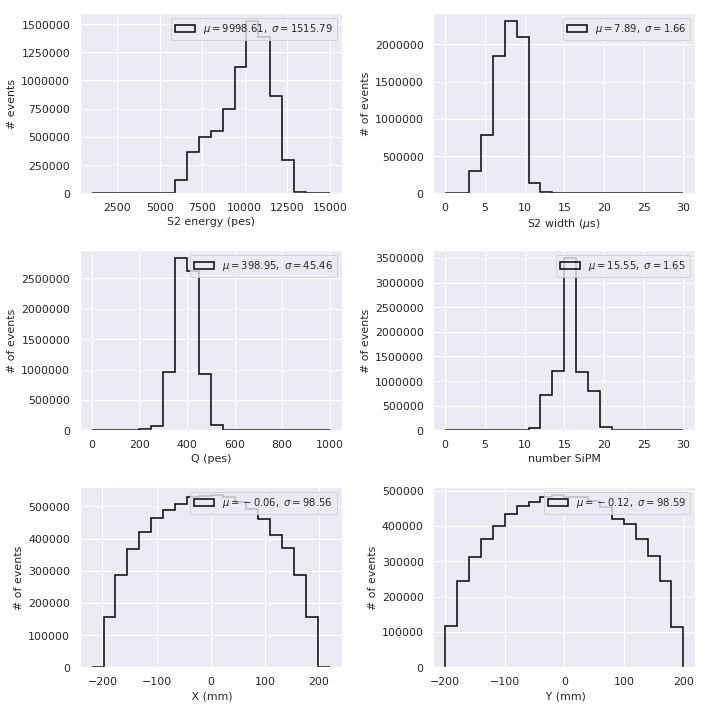

In [35]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Select fiducial region in R

In [36]:
dstf     = dst[dst.R < RFID]

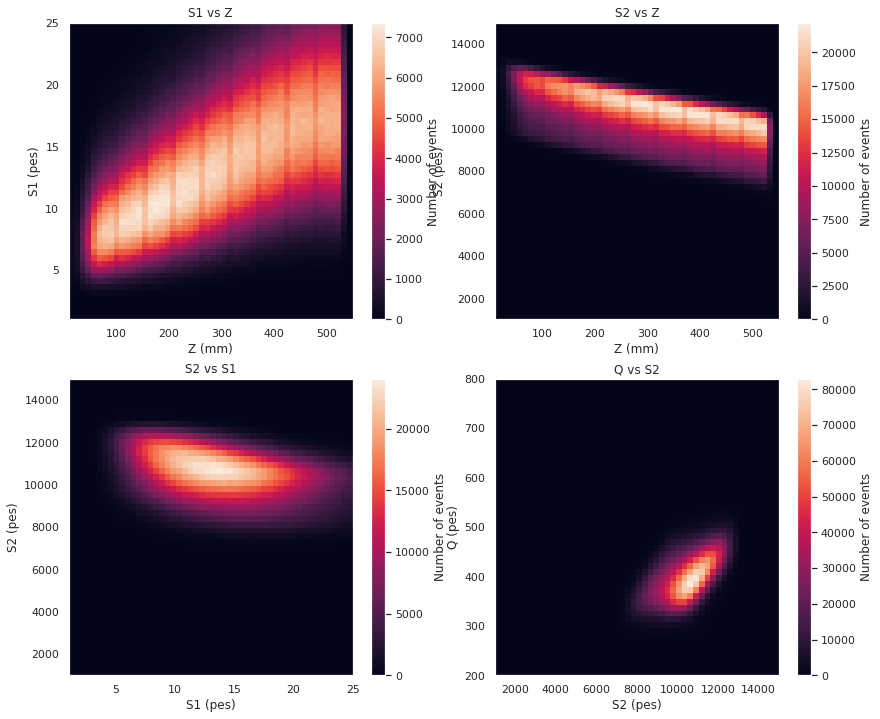

In [37]:
plot_energy_distributions(dstf, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))

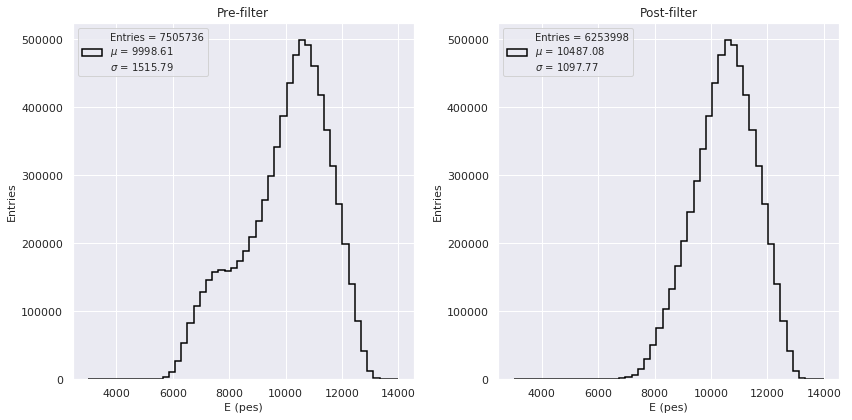

In [38]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(dst.S2e,  bins = 50, range =(3000,14000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dstf.S2e,  bins = 50, range =(3000,14000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

### X vs Y 

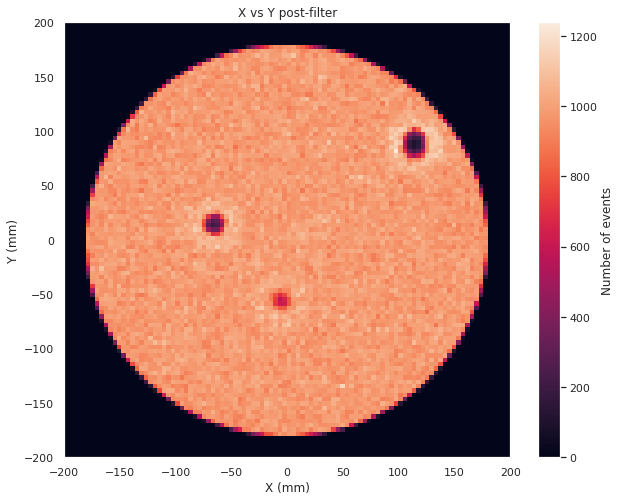

In [39]:
nevt = h2d(dstf.X, dstf.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y post-filter'),
           profile=False,
           figsize=(10,8))

In [40]:
if (write_filtered_dst):
    print('writing filtered dst ', output_dst_filename)
    kdst_write(dst, output_dst_filename)

writing filtered dst  /home/jmbenlloch/next/new/Kr/dst/Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.h5
